## Import necessary libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, TimeDistributed, Flatten, LSTM, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Concatenate, Dense, LSTM, Dropout, BatchNormalization
import keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GRU

## Main dataset

In [ ]:
df = pd.read_csv(<Path_to_dataset>)
# Data Preprocessing

In [ ]:
selected_columns = # Select relevant columns
target_column = # Set target column

In [ ]:
# Normalize the data
scaler = StandardScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

In [ ]:
# Create sequences with a lookback of 5
lookback = 5

def create_sequences(data, target, lookback):
    sequences = []
    targets = []
    for i in range(len(data) - lookback):
        sequence = data.iloc[i:i + lookback][selected_columns].values
        label = target.iloc[i + lookback]
        sequences.append(sequence)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Create sequences and targets
X, y = create_sequences(df[selected_columns], df[target_column], lookback)

## Auxiliary dataset

In [ ]:
df1 = pd.read_csv(<Path_to_Auxiliary_dataset>)
# Data Preprocessing

In [ ]:
df1.fillna(df1.mean(),inplace = True)
df1.isnull().sum()

In [ ]:
selected_columns = # Select relevant columns
target_column = # Set target column

In [ ]:
# Normalize the data
scaler = StandardScaler()
df1[selected_columns] = scaler.fit_transform(df1[selected_columns])

## Custom Metrics Function

In [ ]:
# Define custom metrics functions
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def mape(y_true, y_pred):
    return 100 * K.mean(K.abs((y_true - y_pred) / y_true))

## Model definition - STGCN + LSTM

In [ ]:
# Assuming X has shape (108030, 5, 12) and y has shape (108030,)
X_shape_stgcn = (5, 11, 1)
X_shape_lstm = (5, 11)

In [ ]:
# Define the ST-GCN model
def create_st_gcn_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, activation='relu', kernel_initializer=he_normal())(x)
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model')
    return model

In [ ]:
# Define the simple LSTM model
def create_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    model = Model(inputs=input_layer, outputs=x, name='lstm_model')
    return model

In [ ]:
# Define fusion model
def create_fusion_model(X_shape_stgcn, X_shape_lstm):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn)
    lstm_model = create_lstm_model(X_shape_lstm)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

In [ ]:
fusion_model = create_fusion_model(X_shape_stgcn, X_shape_lstm)
fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

### Check with STGCN and LSTM separately

In [ ]:
def st_gcn_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model')
    return model

In [ ]:
stgcn_model = st_gcn_model(X_shape_stgcn)
stgcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape],run_eagerly=True)

In [ ]:
def lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='lstm_model')
    return model

In [ ]:
lstm_model = lstm_model(X_shape_lstm)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

### Splits

In [ ]:
batch_size = 32
epochs = 10
X_total = [X.reshape(108030,5,11,1), X]

X_shape_stgcn = (5, 11, 1)
X_shape_lstm = (5, 11)

In [ ]:
# Assuming X_total has shape (108030, 5, 11, 1) and y has shape (108030,)
X_total_stgcn = X_total[0]  # Assuming the first channel is for ST-GCN
X_total_lstm = X_total[1]  # Assuming the second channel is for LSTM

In [ ]:
# Splitting the entire dataset into training and validation sets
X_train_stgcn, X_test_stgcn, X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(
    X_total_stgcn, X_total_lstm, y, test_size=0.2, random_state=42, shuffle = True
)

In [ ]:
# Splitting the entire dataset into training and validation sets
X_train_stgcn, X_val_stgcn, X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(
    X_train_stgcn, X_train_lstm, y_train, test_size=0.2, random_state=42, shuffle = True
)

### With Window Size and Dense Layers

In [ ]:
def create_st_gcn_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'st_gcn_model_{window_size}')
    return model

In [ ]:
def create_lstm_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = LSTM(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'lstm_model_{window_size}')
    return model

In [ ]:
def create_fusion_model(X_shape_stgcn, X_shape_lstm, window_size):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn, window_size)
    lstm_model = create_lstm_model(X_shape_lstm, window_size)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

### Training - Fusion Model

In [ ]:
window_sizes = [32, 64, 128, 256]

In [ ]:
all_metrics = {}
models=[]

In [ ]:
for window_size in window_sizes:
    fusion_model = create_fusion_model(X_shape_stgcn, X_shape_lstm, window_size)
    fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae', rmse, r2, mape], run_eagerly=True)

    # Create a unique checkpoint path for each window size
    checkpoint_path = f"model_checkpoint_window_{window_size}_epoch_{{epoch:02d}}.h5"

    # Create the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        save_best_only=False,  # Save the model at every epoch
        verbose=1
    )

    # Train the model with the custom callback
    history = fusion_model.fit(
        [X_train_stgcn, X_train_lstm],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_stgcn, X_val_lstm], y_val),
        callbacks=[model_checkpoint],
        verbose=1
    )

    # Evaluate the model on the test set
    test_metrics = fusion_model.evaluate([X_test_stgcn, X_test_lstm], y_test, verbose=0)

    # Store metrics in a dictionary
    all_metrics[window_size] = {
        'mae': test_metrics[1],
        'rmse': test_metrics[2],
        'r2': test_metrics[3],
        'mape': test_metrics[4]
    }

    models.append(fusion_model)

# Print overall metrics at the end of training for each window size
for window_size, metrics in all_metrics.items():
    print(f"Window Size {window_size}:")
    print(f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, R2: {metrics['r2']:.4f}, MAPE: {metrics['mape']:.4f}")

Epoch 1/10
2161/2161 [==============================] - ETA: 0s - loss: 4598.0376 - mae: 41.9750 - rmse: 60.6837 - r2: 0.6330 - mape: 28.2375
Epoch 1: saving model to model_checkpoint_window_32_epoch_01.h5
2161/2161 [==============================] - 499s 230ms/step - loss: 4598.0376 - mae: 41.9750 - rmse: 60.6837 - r2: 0.6330 - mape: 28.2375 - val_loss: 2502.6692 - val_mae: 31.2692 - val_rmse: 47.2072 - val_r2: 0.8072 - val_mape: 20.9251
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2708.6873 - mae: 31.9337 - rmse: 48.6007 - r2: 0.7866 - mape: 22.0283
Epoch 2: saving model to model_checkpoint_window_32_epoch_02.h5
2161/2161 [==============================] - 520s 241ms/step - loss: 2708.6873 - mae: 31.9337 - rmse: 48.6007 - r2: 0.7866 - mape: 22.0283 - val_loss: 2351.2605 - val_mae: 29.7014 - val_rmse: 45.8117 - val_r2: 0.8176 - val_mape: 19.6735
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2559.4036 - mae: 30.4565 - rmse: 46.8364 - r2: 0.8020 - mape: 20.9473
Epoch 3: saving model to model_checkpoint_window_32_epoch_03.h5
2161/2161 [==============================] - 505s 234ms/step - loss: 2559.4036 - mae: 30.4565 - rmse: 46.8364 - r2: 0.8020 - mape: 20.9473 - val_loss: 2536.4465 - val_mae: 30.6290 - val_rmse: 46.5703 - val_r2: 0.8161 - val_mape: 20.5123
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2484.1118 - mae: 29.7221 - rmse: 46.1968 - r2: 0.8070 - mape: 20.3815
Epoch 4: saving model to model_checkpoint_window_32_epoch_04.h5
2161/2161 [==============================] - 508s 235ms/step - loss: 2484.1118 - mae: 29.7221 - rmse: 46.1968 - r2: 0.8070 - mape: 20.3815 - val_loss: 2242.1465 - val_mae: 28.9168 - val_rmse: 44.8072 - val_r2: 0.8221 - val_mape: 19.9824
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2410.5032 - mae: 29.1713 - rmse: 45.4732 - r2: 0.8102 - mape: 20.0280
Epoch 5: saving model to model_checkpoint_window_32_epoch_05.h5
2161/2161 [==============================] - 532s 246ms/step - loss: 2410.5032 - mae: 29.1713 - rmse: 45.4732 - r2: 0.8102 - mape: 20.0280 - val_loss: 2243.4656 - val_mae: 28.1266 - val_rmse: 44.1522 - val_r2: 0.8298 - val_mape: 19.5824
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2344.2683 - mae: 28.9213 - rmse: 44.9958 - r2: 0.8159 - mape: 19.8510
Epoch 6: saving model to model_checkpoint_window_32_epoch_06.h5
2161/2161 [==============================] - 529s 245ms/step - loss: 2344.2683 - mae: 28.9213 - rmse: 44.9958 - r2: 0.8159 - mape: 19.8510 - val_loss: 2136.6716 - val_mae: 27.9721 - val_rmse: 43.6612 - val_r2: 0.8321 - val_mape: 18.6377
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2296.8743 - mae: 28.4226 - rmse: 44.3615 - r2: 0.8180 - mape: 19.5482
Epoch 7: saving model to model_checkpoint_window_32_epoch_07.h5
2161/2161 [==============================] - 531s 246ms/step - loss: 2296.8743 - mae: 28.4226 - rmse: 44.3615 - r2: 0.8180 - mape: 19.5482 - val_loss: 2108.0964 - val_mae: 27.7617 - val_rmse: 43.3466 - val_r2: 0.8321 - val_mape: 17.9832
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2245.9043 - mae: 28.1470 - rmse: 43.8933 - r2: 0.8207 - mape: 19.3654
Epoch 8: saving model to model_checkpoint_window_32_epoch_08.h5
2161/2161 [==============================] - 517s 239ms/step - loss: 2245.9043 - mae: 28.1470 - rmse: 43.8933 - r2: 0.8207 - mape: 19.3654 - val_loss: 2101.6472 - val_mae: 27.6455 - val_rmse: 43.1982 - val_r2: 0.8344 - val_mape: 17.5379
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2192.1379 - mae: 27.9706 - rmse: 43.5718 - r2: 0.8250 - mape: 19.2568
Epoch 9: saving model to model_checkpoint_window_32_epoch_09.h5
2161/2161 [==============================] - 540s 250ms/step - loss: 2192.1379 - mae: 27.9706 - rmse: 43.5718 - r2: 0.8250 - mape: 19.2568 - val_loss: 2152.8777 - val_mae: 28.6443 - val_rmse: 44.1030 - val_r2: 0.8233 - val_mape: 19.6519
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2155.9980 - mae: 27.7389 - rmse: 43.2179 - r2: 0.8289 - mape: 19.1027
Epoch 10: saving model to model_checkpoint_window_32_epoch_10.h5
2161/2161 [==============================] - 537s 249ms/step - loss: 2155.9980 - mae: 27.7389 - rmse: 43.2179 - r2: 0.8289 - mape: 19.1027 - val_loss: 2061.9287 - val_mae: 27.9225 - val_rmse: 42.9773 - val_r2: 0.8341 - val_mape: 19.3341


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
2161/2161 [==============================] - ETA: 0s - loss: 4298.8296 - mae: 40.7837 - rmse: 59.5721 - r2: 0.6556 - mape: 27.4375
Epoch 1: saving model to model_checkpoint_window_64_epoch_01.h5
2161/2161 [==============================] - 514s 238ms/step - loss: 4298.8296 - mae: 40.7837 - rmse: 59.5721 - r2: 0.6556 - mape: 27.4375 - val_loss: 2614.1763 - val_mae: 32.2355 - val_rmse: 48.1821 - val_r2: 0.7950 - val_mape: 23.3834
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2746.3015 - mae: 32.2079 - rmse: 48.9092 - r2: 0.7889 - mape: 22.1380
Epoch 2: saving model to model_checkpoint_window_64_epoch_02.h5
2161/2161 [==============================] - 513s 237ms/step - loss: 2746.3015 - mae: 32.2079 - rmse: 48.9092 - r2: 0.7889 - mape: 22.1380 - val_loss: 2333.0874 - val_mae: 30.2184 - val_rmse: 45.7276 - val_r2: 0.8161 - val_mape: 21.2680
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2571.5703 - mae: 30.9560 - rmse: 47.3500 - r2: 0.7949 - mape: 21.3029
Epoch 3: saving model to model_checkpoint_window_64_epoch_03.h5
2161/2161 [==============================] - 517s 239ms/step - loss: 2571.5703 - mae: 30.9560 - rmse: 47.3500 - r2: 0.7949 - mape: 21.3029 - val_loss: 2298.6990 - val_mae: 30.0999 - val_rmse: 45.5269 - val_r2: 0.8181 - val_mape: 21.7243
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2449.1182 - mae: 30.0091 - rmse: 46.2406 - r2: 0.8023 - mape: 20.5750
Epoch 4: saving model to model_checkpoint_window_64_epoch_04.h5
2161/2161 [==============================] - 534s 247ms/step - loss: 2449.1182 - mae: 30.0091 - rmse: 46.2406 - r2: 0.8023 - mape: 20.5750 - val_loss: 2144.7595 - val_mae: 28.4214 - val_rmse: 43.8470 - val_r2: 0.8290 - val_mape: 19.8711
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2388.0037 - mae: 29.3755 - rmse: 45.4921 - r2: 0.8099 - mape: 20.1573
Epoch 5: saving model to model_checkpoint_window_64_epoch_05.h5
2161/2161 [==============================] - 547s 253ms/step - loss: 2388.0037 - mae: 29.3755 - rmse: 45.4921 - r2: 0.8099 - mape: 20.1573 - val_loss: 2293.7412 - val_mae: 28.9843 - val_rmse: 45.2127 - val_r2: 0.8152 - val_mape: 19.4538
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2309.4463 - mae: 28.9149 - rmse: 44.9977 - r2: 0.8143 - mape: 19.7638
Epoch 6: saving model to model_checkpoint_window_64_epoch_06.h5
2161/2161 [==============================] - 528s 244ms/step - loss: 2309.4463 - mae: 28.9149 - rmse: 44.9977 - r2: 0.8143 - mape: 19.7638 - val_loss: 2105.0024 - val_mae: 28.1652 - val_rmse: 43.4479 - val_r2: 0.8297 - val_mape: 19.1872
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2244.3113 - mae: 28.4520 - rmse: 44.1890 - r2: 0.8223 - mape: 19.5534
Epoch 7: saving model to model_checkpoint_window_64_epoch_07.h5
2161/2161 [==============================] - 533s 246ms/step - loss: 2244.3113 - mae: 28.4520 - rmse: 44.1890 - r2: 0.8223 - mape: 19.5534 - val_loss: 2171.8594 - val_mae: 27.1859 - val_rmse: 43.6308 - val_r2: 0.8333 - val_mape: 18.0174
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2200.9978 - mae: 28.2750 - rmse: 43.8477 - r2: 0.8225 - mape: 19.3718
Epoch 8: saving model to model_checkpoint_window_64_epoch_08.h5
2161/2161 [==============================] - 508s 235ms/step - loss: 2200.9978 - mae: 28.2750 - rmse: 43.8477 - r2: 0.8225 - mape: 19.3718 - val_loss: 2160.8738 - val_mae: 28.9390 - val_rmse: 43.9355 - val_r2: 0.8256 - val_mape: 20.5368
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2163.5518 - mae: 27.9911 - rmse: 43.5029 - r2: 0.8273 - mape: 19.2112
Epoch 9: saving model to model_checkpoint_window_64_epoch_09.h5
2161/2161 [==============================] - 528s 244ms/step - loss: 2163.5518 - mae: 27.9911 - rmse: 43.5029 - r2: 0.8273 - mape: 19.2112 - val_loss: 2073.1343 - val_mae: 27.9158 - val_rmse: 42.9960 - val_r2: 0.8368 - val_mape: 19.2062
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2126.7141 - mae: 27.9039 - rmse: 43.2825 - r2: 0.8284 - mape: 19.1398
Epoch 10: saving model to model_checkpoint_window_64_epoch_10.h5
2161/2161 [==============================] - 511s 237ms/step - loss: 2126.7141 - mae: 27.9039 - rmse: 43.2825 - r2: 0.8284 - mape: 19.1398 - val_loss: 2139.7246 - val_mae: 29.2294 - val_rmse: 44.0317 - val_r2: 0.8242 - val_mape: 21.0490


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
2161/2161 [==============================] - ETA: 0s - loss: 4478.2583 - mae: 41.3624 - rmse: 60.3031 - r2: 0.6559 - mape: 27.8351
Epoch 1: saving model to model_checkpoint_window_128_epoch_01.h5
2161/2161 [==============================] - 526s 244ms/step - loss: 4478.2583 - mae: 41.3624 - rmse: 60.3031 - r2: 0.6559 - mape: 27.8351 - val_loss: 2672.9993 - val_mae: 31.7546 - val_rmse: 48.3403 - val_r2: 0.7980 - val_mape: 20.4542
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2776.6692 - mae: 32.0404 - rmse: 49.1066 - r2: 0.7831 - mape: 21.8208
Epoch 2: saving model to model_checkpoint_window_128_epoch_02.h5
2161/2161 [==============================] - 537s 249ms/step - loss: 2776.6692 - mae: 32.0404 - rmse: 49.1066 - r2: 0.7831 - mape: 21.8208 - val_loss: 2466.3936 - val_mae: 30.6284 - val_rmse: 46.8399 - val_r2: 0.8101 - val_mape: 21.9235
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2599.7373 - mae: 30.8832 - rmse: 47.4587 - r2: 0.7949 - mape: 21.1384
Epoch 3: saving model to model_checkpoint_window_128_epoch_03.h5
2161/2161 [==============================] - 539s 250ms/step - loss: 2599.7373 - mae: 30.8832 - rmse: 47.4587 - r2: 0.7949 - mape: 21.1384 - val_loss: 2388.8308 - val_mae: 30.1485 - val_rmse: 46.0282 - val_r2: 0.8156 - val_mape: 21.4322
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2548.0457 - mae: 30.3093 - rmse: 46.8640 - r2: 0.7997 - mape: 20.7092
Epoch 4: saving model to model_checkpoint_window_128_epoch_04.h5
2161/2161 [==============================] - 523s 242ms/step - loss: 2548.0457 - mae: 30.3093 - rmse: 46.8640 - r2: 0.7997 - mape: 20.7092 - val_loss: 2278.7981 - val_mae: 29.3864 - val_rmse: 44.9493 - val_r2: 0.8236 - val_mape: 19.7526
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2437.5950 - mae: 29.7601 - rmse: 45.8786 - r2: 0.8087 - mape: 20.3457
Epoch 5: saving model to model_checkpoint_window_128_epoch_05.h5
2161/2161 [==============================] - 537s 249ms/step - loss: 2437.5950 - mae: 29.7601 - rmse: 45.8786 - r2: 0.8087 - mape: 20.3457 - val_loss: 2179.7798 - val_mae: 28.8329 - val_rmse: 44.1231 - val_r2: 0.8273 - val_mape: 18.8477
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2334.8286 - mae: 29.2258 - rmse: 45.0848 - r2: 0.8141 - mape: 20.1052
Epoch 6: saving model to model_checkpoint_window_128_epoch_06.h5
2161/2161 [==============================] - 539s 249ms/step - loss: 2334.8286 - mae: 29.2258 - rmse: 45.0848 - r2: 0.8141 - mape: 20.1052 - val_loss: 2307.0889 - val_mae: 30.5312 - val_rmse: 45.4553 - val_r2: 0.8176 - val_mape: 19.6854
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2314.9460 - mae: 29.0195 - rmse: 44.8968 - r2: 0.8148 - mape: 19.9172
Epoch 7: saving model to model_checkpoint_window_128_epoch_07.h5
2161/2161 [==============================] - 535s 248ms/step - loss: 2314.9460 - mae: 29.0195 - rmse: 44.8968 - r2: 0.8148 - mape: 19.9172 - val_loss: 2184.2419 - val_mae: 28.3498 - val_rmse: 43.9795 - val_r2: 0.8292 - val_mape: 19.4192
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2265.2295 - mae: 28.6513 - rmse: 44.4114 - r2: 0.8198 - mape: 19.6662
Epoch 8: saving model to model_checkpoint_window_128_epoch_08.h5
2161/2161 [==============================] - 536s 248ms/step - loss: 2265.2295 - mae: 28.6513 - rmse: 44.4114 - r2: 0.8198 - mape: 19.6662 - val_loss: 2161.2881 - val_mae: 29.3075 - val_rmse: 44.2152 - val_r2: 0.8281 - val_mape: 18.2213
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2206.9656 - mae: 28.3001 - rmse: 43.8298 - r2: 0.8247 - mape: 19.4430
Epoch 9: saving model to model_checkpoint_window_128_epoch_09.h5
2161/2161 [==============================] - 534s 247ms/step - loss: 2206.9656 - mae: 28.3001 - rmse: 43.8298 - r2: 0.8247 - mape: 19.4430 - val_loss: 2058.3579 - val_mae: 28.5453 - val_rmse: 42.9640 - val_r2: 0.8372 - val_mape: 20.2864
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2150.7043 - mae: 28.2137 - rmse: 43.3603 - r2: 0.8271 - mape: 19.4879
Epoch 10: saving model to model_checkpoint_window_128_epoch_10.h5
2161/2161 [==============================] - 526s 244ms/step - loss: 2150.7043 - mae: 28.2137 - rmse: 43.3603 - r2: 0.8271 - mape: 19.4879 - val_loss: 2060.9631 - val_mae: 28.5902 - val_rmse: 43.0510 - val_r2: 0.8346 - val_mape: 21.1235


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
2161/2161 [==============================] - ETA: 0s - loss: 4522.3926 - mae: 41.5076 - rmse: 60.4071 - r2: 0.6487 - mape: 28.2477
Epoch 1: saving model to model_checkpoint_window_256_epoch_01.h5
2161/2161 [==============================] - 534s 247ms/step - loss: 4522.3926 - mae: 41.5076 - rmse: 60.4071 - r2: 0.6487 - mape: 28.2477 - val_loss: 3043.0022 - val_mae: 33.3327 - val_rmse: 51.0308 - val_r2: 0.7833 - val_mape: 20.6361
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2784.2908 - mae: 32.1877 - rmse: 49.0652 - r2: 0.7823 - mape: 22.0816
Epoch 2: saving model to model_checkpoint_window_256_epoch_02.h5
2161/2161 [==============================] - 509s 236ms/step - loss: 2784.2908 - mae: 32.1877 - rmse: 49.0652 - r2: 0.7823 - mape: 22.0816 - val_loss: 2454.9639 - val_mae: 30.3532 - val_rmse: 46.3808 - val_r2: 0.8141 - val_mape: 19.6603
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2592.3027 - mae: 30.8124 - rmse: 47.3606 - r2: 0.7867 - mape: 21.2053
Epoch 3: saving model to model_checkpoint_window_256_epoch_03.h5
2161/2161 [==============================] - 534s 247ms/step - loss: 2592.3027 - mae: 30.8124 - rmse: 47.3606 - r2: 0.7867 - mape: 21.2053 - val_loss: 2285.4141 - val_mae: 29.9991 - val_rmse: 45.2188 - val_r2: 0.8218 - val_mape: 19.3040
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2485.5413 - mae: 29.9494 - rmse: 46.4585 - r2: 0.8013 - mape: 20.6248
Epoch 4: saving model to model_checkpoint_window_256_epoch_04.h5
2161/2161 [==============================] - 520s 241ms/step - loss: 2485.5413 - mae: 29.9494 - rmse: 46.4585 - r2: 0.8013 - mape: 20.6248 - val_loss: 2213.8181 - val_mae: 28.6910 - val_rmse: 44.3212 - val_r2: 0.8279 - val_mape: 19.1904
Epoch 5/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2412.9648 - mae: 29.4297 - rmse: 45.6731 - r2: 0.8087 - mape: 20.2279
Epoch 5: saving model to model_checkpoint_window_256_epoch_05.h5
2161/2161 [==============================] - 537s 248ms/step - loss: 2412.9648 - mae: 29.4297 - rmse: 45.6731 - r2: 0.8087 - mape: 20.2279 - val_loss: 2191.0522 - val_mae: 28.2819 - val_rmse: 44.0513 - val_r2: 0.8266 - val_mape: 19.7941
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2346.8511 - mae: 28.9788 - rmse: 45.0359 - r2: 0.8143 - mape: 19.8792
Epoch 6: saving model to model_checkpoint_window_256_epoch_06.h5
2161/2161 [==============================] - 513s 238ms/step - loss: 2346.8511 - mae: 28.9788 - rmse: 45.0359 - r2: 0.8143 - mape: 19.8792 - val_loss: 2201.7600 - val_mae: 27.7278 - val_rmse: 43.9042 - val_r2: 0.8327 - val_mape: 19.0055
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2277.4709 - mae: 28.5692 - rmse: 44.4477 - r2: 0.8230 - mape: 19.6689
Epoch 7: saving model to model_checkpoint_window_256_epoch_07.h5
2161/2161 [==============================] - 510s 236ms/step - loss: 2277.4709 - mae: 28.5692 - rmse: 44.4477 - r2: 0.8230 - mape: 19.6689 - val_loss: 2137.5764 - val_mae: 28.7840 - val_rmse: 43.6397 - val_r2: 0.8327 - val_mape: 19.6870
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2190.9182 - mae: 28.1742 - rmse: 43.6950 - r2: 0.8242 - mape: 19.4218
Epoch 8: saving model to model_checkpoint_window_256_epoch_08.h5
2161/2161 [==============================] - 509s 236ms/step - loss: 2190.9182 - mae: 28.1742 - rmse: 43.6950 - r2: 0.8242 - mape: 19.4218 - val_loss: 2197.5405 - val_mae: 27.6449 - val_rmse: 43.6753 - val_r2: 0.8317 - val_mape: 18.2960
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2166.4287 - mae: 28.0300 - rmse: 43.6220 - r2: 0.8282 - mape: 19.2756
Epoch 9: saving model to model_checkpoint_window_256_epoch_09.h5
2161/2161 [==============================] - 501s 232ms/step - loss: 2166.4287 - mae: 28.0300 - rmse: 43.6220 - r2: 0.8282 - mape: 19.2756 - val_loss: 2123.3135 - val_mae: 27.4658 - val_rmse: 43.2597 - val_r2: 0.8347 - val_mape: 18.9662
Epoch 10/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2161/2161 [==============================] - ETA: 0s - loss: 2144.9255 - mae: 27.8045 - rmse: 43.2006 - r2: 0.8282 - mape: 19.1476
Epoch 10: saving model to model_checkpoint_window_256_epoch_10.h5
2161/2161 [==============================] - 501s 232ms/step - loss: 2144.9255 - mae: 27.8045 - rmse: 43.2006 - r2: 0.8282 - mape: 19.1476 - val_loss: 2196.4368 - val_mae: 28.0942 - val_rmse: 43.9095 - val_r2: 0.8234 - val_mape: 19.0621


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Window Size 32:
MAE: 28.4126, RMSE: 44.4922, R2: 0.8236, MAPE: 19.6332
Window Size 64:
MAE: 29.9944, RMSE: 46.2928, R2: 0.8060, MAPE: 21.4264
Window Size 128:
MAE: 29.0195, RMSE: 44.4831, R2: 0.8193, MAPE: 21.4075
Window Size 256:
MAE: 28.6755, RMSE: 45.6397, R2: 0.8071, MAPE: 19.4160


In [ ]:
def create_fusion_model(X_shape_stgcn, X_shape_lstm, st_gcn_units, lstm_units):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn, st_gcn_units)
    lstm_model = create_lstm_model(X_shape_lstm, lstm_units)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

### Training - LSTM Model

In [ ]:
history_lstm = lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_lstm, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 195s 181ms/step - loss: 9471.0723 - mae: 62.1694 - rmse: 86.9256 - r2: 0.2738 - mape: 40.6105 - val_loss: 3941.4373 - val_mae: 39.7966 - val_rmse: 60.3704 - val_r2: 0.7102 - val_mape: 28.6752
Epoch 2/15
1081/1081 [==============================] - 196s 181ms/step - loss: 3755.0439 - mae: 38.5947 - rmse: 58.7570 - r2: 0.7248 - mape: 27.2625 - val_loss: 3364.9153 - val_mae: 35.5135 - val_rmse: 55.2293 - val_r2: 0.7588 - val_mape: 24.6773
Epoch 3/15
1081/1081 [==============================] - 171s 158ms/step - loss: 3430.9060 - mae: 36.4285 - rmse: 55.8500 - r2: 0.7519 - mape: 25.7352 - val_loss: 3163.9380 - val_mae: 35.6291 - val_rmse: 54.0880 - val_r2: 0.7690 - val_mape: 25.8832
Epoch 4/15
1081/1081 [==============================] - 186s 172ms/step - loss: 3194.5615 - mae: 35.2211 - rmse: 54.0705 - r2: 0.7643 - mape: 24.8391 - val_loss: 3139.7043 - val_mae: 35.5828 - val_rmse: 53.8608 - val_r2: 0.7706 - val_mape: 23.0002
Epoch 5/

### Training - STGCN Model

In [ ]:
history_stgcn = stgcn_model.fit(
    X_train_stgcn,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_stgcn, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 260s 241ms/step - loss: 4568.7144 - mae: 41.9772 - rmse: 62.4141 - r2: 0.6534 - mape: 27.9897 - val_loss: 2968.9170 - val_mae: 35.2237 - val_rmse: 52.5481 - val_r2: 0.7807 - val_mape: 21.1401
Epoch 2/15
1081/1081 [==============================] - 242s 224ms/step - loss: 2974.0566 - mae: 33.6459 - rmse: 52.2570 - r2: 0.7754 - mape: 22.8258 - val_loss: 2494.3647 - val_mae: 30.9000 - val_rmse: 48.1653 - val_r2: 0.8145 - val_mape: 21.5054
Epoch 3/15
1081/1081 [==============================] - 250s 231ms/step - loss: 2826.2253 - mae: 32.7724 - rmse: 50.9693 - r2: 0.7889 - mape: 22.3350 - val_loss: 2326.4482 - val_mae: 29.9010 - val_rmse: 46.6530 - val_r2: 0.8212 - val_mape: 20.5712
Epoch 4/15
1081/1081 [==============================] - 243s 225ms/step - loss: 2648.2998 - mae: 31.4344 - rmse: 49.2577 - r2: 0.8031 - mape: 21.4330 - val_loss: 2272.3108 - val_mae: 28.9832 - val_rmse: 46.0588 - val_r2: 0.8277 - val_mape: 19.4089
Epoch 5/

### Plots - MAE

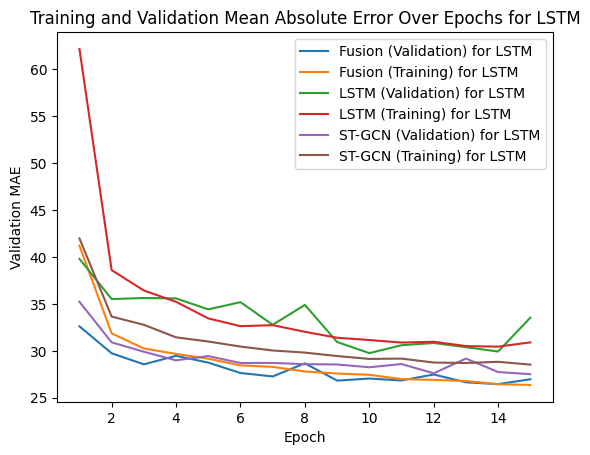

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion.history['val_mae'], label='Fusion (Validation) for LSTM')
plt.plot(epochs_range, history_fusion.history['mae'], label='Fusion (Training) for LSTM')
plt.plot(epochs_range, history_lstm.history['val_mae'], label='LSTM (Validation) for LSTM')
plt.plot(epochs_range, history_lstm.history['mae'], label='LSTM (Training) for LSTM')
plt.plot(epochs_range, history_stgcn.history['val_mae'], label='ST-GCN (Validation) for LSTM')
plt.plot(epochs_range, history_stgcn.history['mae'], label='ST-GCN (Training) for LSTM')

plt.title('Training and Validation Mean Absolute Error Over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - RMSE

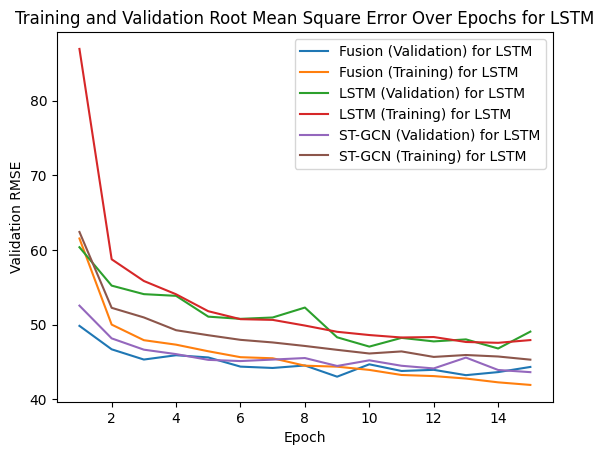

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion.history['val_rmse'], label='Fusion (Validation) for LSTM')
plt.plot(epochs_range, history_fusion.history['rmse'], label='Fusion (Training) for LSTM')
plt.plot(epochs_range, history_lstm.history['val_rmse'], label='LSTM (Validation) for LSTM')
plt.plot(epochs_range, history_lstm.history['rmse'], label='LSTM (Training) for LSTM')
plt.plot(epochs_range, history_stgcn.history['val_rmse'], label='ST-GCN (Validation) for LSTM')
plt.plot(epochs_range, history_stgcn.history['rmse'], label='ST-GCN (Training) for LSTM')

plt.title('Training and Validation Root Mean Square Error Over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - R2 Score

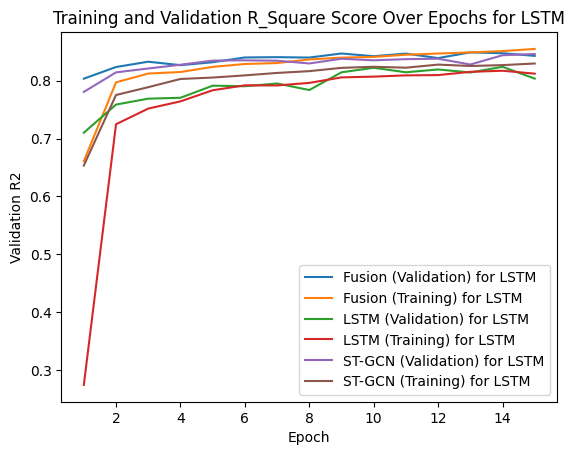

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion.history['val_r2'], label='Fusion (Validation) for LSTM')
plt.plot(epochs_range, history_fusion.history['r2'], label='Fusion (Training) for LSTM')
plt.plot(epochs_range, history_lstm.history['val_r2'], label='LSTM (Validation) for LSTM')
plt.plot(epochs_range, history_lstm.history['r2'], label='LSTM (Training) for LSTM')
plt.plot(epochs_range, history_stgcn.history['val_r2'], label='ST-GCN (Validation) for LSTM')
plt.plot(epochs_range, history_stgcn.history['r2'], label='ST-GCN (Training) for LSTM')

plt.title('Training and Validation R_Square Score Over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation R2')
plt.legend()  # This will use the labels defined above
plt.show()


### Plots - MAPE

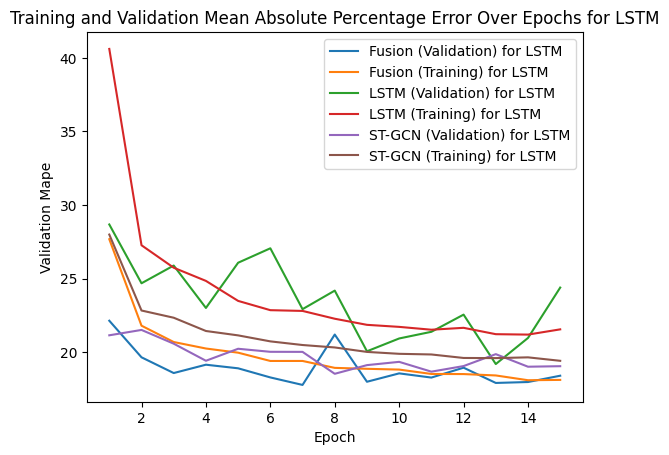

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion.history['val_mape'], label='Fusion (Validation) for LSTM')
plt.plot(epochs_range, history_fusion.history['mape'], label='Fusion (Training) for LSTM')
plt.plot(epochs_range, history_lstm.history['val_mape'], label='LSTM (Validation) for LSTM ')
plt.plot(epochs_range, history_lstm.history['mape'], label='LSTM (Training) for LSTM')
plt.plot(epochs_range, history_stgcn.history['val_mape'], label='ST-GCN (Validation) for LSTM')
plt.plot(epochs_range, history_stgcn.history['mape'], label='ST-GCN (Training) for LSTM')

plt.title('Training and Validation Mean Absolute Percentage Error Over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation Mape')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - Loss over Epochs

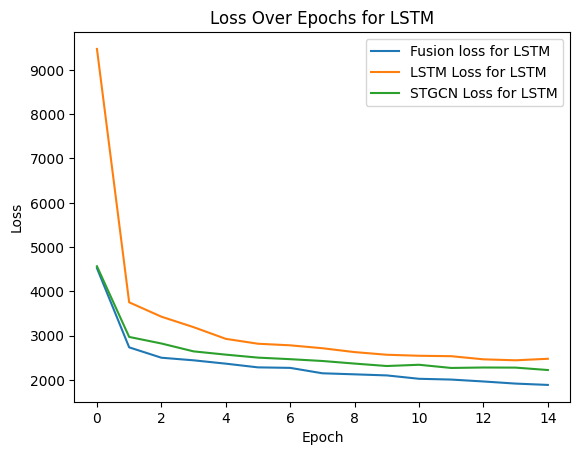

In [ ]:
# Plot loss over epochs - LSTM
plt.plot(history_fusion.history['loss'], label = 'Fusion loss for LSTM')
plt.plot(history_lstm.history['loss'], label = 'LSTM Loss for LSTM')
plt.plot(history_stgcn.history['loss'], label = 'STGCN Loss for LSTM')
plt.title('Loss Over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plots - Predicted vs Actual

In [ ]:
y_preds = fusion_model.predict([X[-100:].reshape(100,5,11,1),X[-100:]])

4/4 [==============================] - 0s 53ms/step


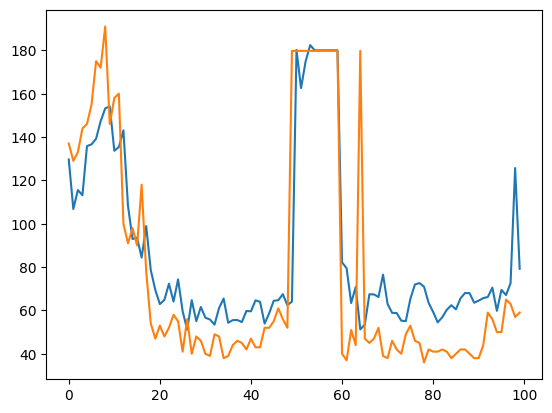

In [ ]:
plt.plot(y_preds)
plt.plot(y[-100:])

## Model Definition - STGCN + BiLSTM

In [ ]:
def create_st_gcn_model2(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer='he_normal')(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(64, activation='relu', kernel_initializer='he_normal'))(x)  # Use Bidirectional LSTM
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model2')
    return model

In [ ]:
def create_bilstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, activation='relu', kernel_initializer='he_normal'))(input_layer)  # Use Bidirectional LSTM
    model = Model(inputs=input_layer, outputs=x, name='bilstm_model')
    return model

In [ ]:
def create_fusion_model(X_shape_stgcn, X_shape_lstm):
    st_gcn_model2 = create_st_gcn_model2(X_shape_stgcn)
    bilstm_model = create_bilstm_model(X_shape_lstm)
    combined_input = concatenate([st_gcn_model2.output, bilstm_model.output])
    fusion_layer2 = Dense(32, activation='relu')(combined_input)
    final_output2 = Dense(1, name='output_layer')(fusion_layer2)
    final_model2 = Model(inputs=[st_gcn_model2.input, bilstm_model.input], outputs=final_output2)
    return final_model2

In [ ]:
fusion_model_bilstm = create_fusion_model(X_shape_stgcn, X_shape_lstm)
fusion_model_bilstm.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

### With Dense Layers

In [ ]:
def st_gcn_model2(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model2')
    return model

In [ ]:
stgcn_model2 = st_gcn_model2(X_shape_stgcn)
stgcn_model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape],run_eagerly=True)

In [ ]:
def bilstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, activation='relu', kernel_initializer=he_normal()))(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='bilstm_model')
    return model

In [ ]:
bilstm_model = bilstm_model(X_shape_lstm)
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

### With Window Size

In [ ]:
def create_st_gcn_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(64, activation='relu', kernel_initializer=he_normal()))(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'st_gcn_model_{window_size}')
    return model

In [ ]:
def create_lstm_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(32, activation='relu', kernel_initializer=he_normal()))(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'lstm_model_{window_size}')
    return model

In [ ]:
def create_fusion_model_bilstm(X_shape_stgcn, X_shape_lstm, window_size):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn, window_size)
    lstm_model = create_lstm_model(X_shape_lstm, window_size)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

### Training - Fusion Model

In [ ]:
window_sizes = [32, 64, 128, 256]

In [ ]:
all_metrics = {}
models=[]

In [ ]:
for window_size in window_sizes:
    fusion_model = create_fusion_model_bilstm(X_shape_stgcn, X_shape_lstm, window_size)
    fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae', rmse, r2, mape], run_eagerly=True)

    # Create a unique checkpoint path for each window size
    checkpoint_path = f"model_checkpoint_window_{window_size}_epoch_{{epoch:02d}}.h5"

    # Create the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        save_best_only=False,  # Save the model at every epoch
        verbose=1
    )

    # Train the model with the custom callback
    history = fusion_model.fit(
        [X_train_stgcn, X_train_lstm],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_stgcn, X_val_lstm], y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_metrics = fusion_model.evaluate([X_test_stgcn, X_test_lstm], y_test, verbose=0)

    # Store metrics in a dictionary
    all_metrics[window_size] = {
        'mae': test_metrics[1],
        'rmse': test_metrics[2],
        'r2': test_metrics[3],
        'mape': test_metrics[4]
    }

    models.append(fusion_model)

# Print overall metrics at the end of training for each window size
for window_size, metrics in all_metrics.items():
    print(f"Window Size {window_size}:")
    print(f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, R2: {metrics['r2']:.4f}, MAPE: {metrics['mape']:.4f}")

Epoch 1/10
2161/2161 [==============================] - 695s 322ms/step - loss: 4392.9209 - mae: 39.2529 - rmse: 57.0553 - r2: 0.6446 - mape: 26.3242 - val_loss: 2536.0256 - val_mae: 33.0055 - val_rmse: 48.3072 - val_r2: 0.7870 - val_mape: 22.8381
Epoch 2/10
2161/2161 [==============================] - 754s 349ms/step - loss: 2516.5574 - mae: 30.5728 - rmse: 46.8501 - r2: 0.7997 - mape: 21.0094 - val_loss: 2209.5613 - val_mae: 28.0434 - val_rmse: 44.1374 - val_r2: 0.8293 - val_mape: 18.7986
Epoch 3/10
2161/2161 [==============================] - 689s 319ms/step - loss: 2363.0906 - mae: 29.1205 - rmse: 45.2616 - r2: 0.8089 - mape: 19.9969 - val_loss: 2068.8848 - val_mae: 28.0069 - val_rmse: 43.1698 - val_r2: 0.8326 - val_mape: 18.3664
Epoch 4/10
2161/2161 [==============================] - 684s 317ms/step - loss: 2306.2124 - mae: 28.7208 - rmse: 44.6735 - r2: 0.8148 - mape: 19.6426 - val_loss: 2017.4667 - val_mae: 27.3302 - val_rmse: 42.4454 - val_r2: 0.8396 - val_mape: 18.1506
Epoch 5/

## Model Definition - STGCN + GRU

In [ ]:
def create_st_gcn_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = GRU(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'st_gcn_model_{window_size}')
    return model

In [ ]:
def create_lstm_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = GRU(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'lstm_model_{window_size}')
    return model

In [ ]:
def create_fusion_model_gru(X_shape_stgcn, X_shape_lstm, window_size):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn, window_size)
    lstm_model = create_lstm_model(X_shape_lstm, window_size)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

### Training

In [ ]:
window_sizes = [32, 64, 128, 256]

In [ ]:
all_metrics = {}
models=[]

In [ ]:
for window_size in window_sizes:
    fusion_model = create_fusion_model_gru(X_shape_stgcn, X_shape_lstm, window_size)
    fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae', rmse, r2, mape], run_eagerly=True)

    # Create a unique checkpoint path for each window size
    checkpoint_path = f"model_checkpoint_window_{window_size}_epoch_{{epoch:02d}}.h5"

    # Create the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        save_best_only=False,  # Save the model at every epoch
        verbose=1
    )

    # Train the model with the custom callback
    history = fusion_model.fit(
        [X_train_stgcn, X_train_lstm],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_stgcn, X_val_lstm], y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_metrics = fusion_model.evaluate([X_test_stgcn, X_test_lstm], y_test, verbose=0)

    # Store metrics in a dictionary
    all_metrics[window_size] = {
        'mae': test_metrics[1],
        'rmse': test_metrics[2],
        'r2': test_metrics[3],
        'mape': test_metrics[4]
    }

    models.append(fusion_model)

# Print overall metrics at the end of training for each window size
for window_size, metrics in all_metrics.items():
    print(f"Window Size {window_size}:")
    print(f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, R2: {metrics['r2']:.4f}, MAPE: {metrics['mape']:.4f}")

Epoch 1/10
2161/2161 [==============================] - 302s 139ms/step - loss: 4744.0293 - mae: 42.5418 - rmse: 61.3283 - r2: 0.6332 - mape: 28.4141 - val_loss: 2539.1362 - val_mae: 31.5499 - val_rmse: 47.8199 - val_r2: 0.7951 - val_mape: 21.2378
Epoch 2/10
2161/2161 [==============================] - 304s 141ms/step - loss: 2720.7141 - mae: 31.8669 - rmse: 48.7048 - r2: 0.7855 - mape: 21.8506 - val_loss: 2389.1616 - val_mae: 30.7361 - val_rmse: 46.2664 - val_r2: 0.8100 - val_mape: 21.5327
Epoch 3/10
2161/2161 [==============================] - 300s 139ms/step - loss: 2514.9702 - mae: 30.2640 - rmse: 46.7742 - r2: 0.7996 - mape: 20.7904 - val_loss: 2162.6445 - val_mae: 28.2492 - val_rmse: 43.7896 - val_r2: 0.8293 - val_mape: 19.1312
Epoch 4/10
2161/2161 [==============================] - 308s 143ms/step - loss: 2433.6265 - mae: 29.6236 - rmse: 45.9228 - r2: 0.8066 - mape: 20.2652 - val_loss: 2171.6416 - val_mae: 28.0275 - val_rmse: 43.9479 - val_r2: 0.8268 - val_mape: 18.3673
Epoch 5/

### STGCN + GRU

In [ ]:
from tensorflow.keras.layers import GRU

def create_st_gcn_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = GRU(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'st_gcn_model_{window_size}')
    return model

def create_lstm_model(input_shape, window_size):
    input_layer = Input(shape=input_shape)
    x = GRU(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name=f'lstm_model_{window_size}')
    return model

def create_fusion_model_gru(X_shape_stgcn, X_shape_lstm, window_size):
    st_gcn_model = create_st_gcn_model(X_shape_stgcn, window_size)
    lstm_model = create_lstm_model(X_shape_lstm, window_size)
    combined_input = concatenate([st_gcn_model.output, lstm_model.output])
    fusion_layer = Dense(32, activation='relu')(combined_input)
    final_output = Dense(1, name='output_layer')(fusion_layer)
    final_model = Model(inputs=[st_gcn_model.input, lstm_model.input], outputs=final_output)
    return final_model

In [ ]:
window_sizes = [32, 64, 128, 256]

all_metrics = {}
models=[]
for window_size in window_sizes:
    fusion_model = create_fusion_model_gru(X_shape_stgcn, X_shape_lstm, window_size)
    fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae', rmse, r2, mape], run_eagerly=True)

    # Create a unique checkpoint path for each window size
    checkpoint_path = f"model_checkpoint_window_{window_size}_epoch_{{epoch:02d}}.h5"

    # Create the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        save_best_only=False,  # Save the model at every epoch
        verbose=1
    )

    # Train the model with the custom callback
    history = fusion_model.fit(
        [X_train_stgcn, X_train_lstm],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_stgcn, X_val_lstm], y_val),
        verbose=1
    )

    # Evaluate the model on the test set
    test_metrics = fusion_model.evaluate([X_test_stgcn, X_test_lstm], y_test, verbose=0)

    # Store metrics in a dictionary
    all_metrics[window_size] = {
        'mae': test_metrics[1],
        'rmse': test_metrics[2],
        'r2': test_metrics[3],
        'mape': test_metrics[4]
    }

    models.append(fusion_model)

# Print overall metrics at the end of training for each window size
for window_size, metrics in all_metrics.items():
    print(f"Window Size {window_size}:")
    print(f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, R2: {metrics['r2']:.4f}, MAPE: {metrics['mape']:.4f}")

## Training - BiLSTM Model

In [ ]:
history_bilstm = bilstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_lstm, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 196s 181ms/step - loss: 7046.9941 - mae: 52.3718 - rmse: 72.4307 - r2: 0.4553 - mape: 35.1879 - val_loss: 2793.6387 - val_mae: 34.1498 - val_rmse: 51.2187 - val_r2: 0.7852 - val_mape: 23.3753
Epoch 2/15
1081/1081 [==============================] - 203s 188ms/step - loss: 2781.4531 - mae: 32.7655 - rmse: 50.6927 - r2: 0.7869 - mape: 23.7473 - val_loss: 2534.6211 - val_mae: 31.9142 - val_rmse: 48.7786 - val_r2: 0.8043 - val_mape: 22.0167
Epoch 3/15
1081/1081 [==============================] - 202s 187ms/step - loss: 2525.0051 - mae: 31.0396 - rmse: 48.2247 - r2: 0.8059 - mape: 22.4149 - val_loss: 2416.0645 - val_mae: 30.3283 - val_rmse: 47.4494 - val_r2: 0.8102 - val_mape: 21.2789
Epoch 4/15
1081/1081 [==============================] - 193s 179ms/step - loss: 2418.0962 - mae: 30.0371 - rmse: 47.2480 - r2: 0.8144 - mape: 21.5069 - val_loss: 2273.0696 - val_mae: 29.6450 - val_rmse: 46.0411 - val_r2: 0.8267 - val_mape: 20.4776
Epoch 5/

## Training - STGCN Model

In [ ]:
history_stgcn2 = stgcn_model2.fit(
    X_train_stgcn,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_stgcn, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 213s 197ms/step - loss: 4535.5991 - mae: 41.8087 - rmse: 62.2349 - r2: 0.6584 - mape: 27.8694 - val_loss: 2750.6123 - val_mae: 33.5503 - val_rmse: 50.6449 - val_r2: 0.7934 - val_mape: 21.6272
Epoch 2/15
1081/1081 [==============================] - 202s 187ms/step - loss: 3004.0491 - mae: 33.4445 - rmse: 52.3204 - r2: 0.7806 - mape: 22.5840 - val_loss: 2616.7246 - val_mae: 32.4638 - val_rmse: 49.3261 - val_r2: 0.8039 - val_mape: 20.1787
Epoch 3/15
1081/1081 [==============================] - 212s 196ms/step - loss: 2849.3484 - mae: 32.3983 - rmse: 51.0010 - r2: 0.7886 - mape: 21.9289 - val_loss: 2579.2981 - val_mae: 31.0746 - val_rmse: 48.6406 - val_r2: 0.8137 - val_mape: 19.5787
Epoch 4/15
1081/1081 [==============================] - 197s 182ms/step - loss: 2714.9995 - mae: 31.8032 - rmse: 49.8917 - r2: 0.7970 - mape: 21.4672 - val_loss: 2375.0913 - val_mae: 30.2184 - val_rmse: 46.7569 - val_r2: 0.8253 - val_mape: 20.0733
Epoch 5/

## Plot - MAE (BiLSTM)

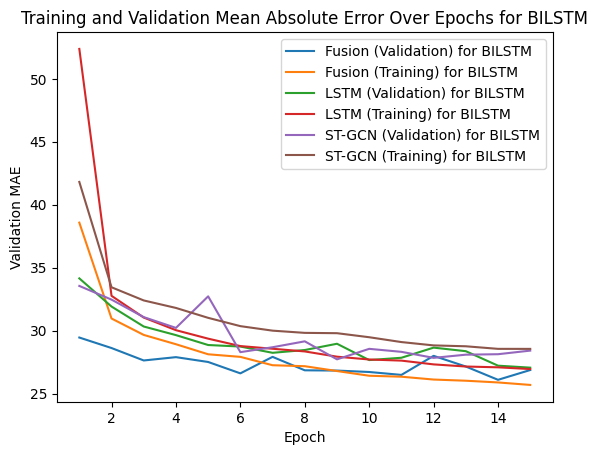

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_bilstm.history['val_mae'], label='Fusion (Validation) for BILSTM')
plt.plot(epochs_range, history_fusion_bilstm.history['mae'], label='Fusion (Training) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['val_mae'], label='LSTM (Validation) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['mae'], label='LSTM (Training) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['val_mae'], label='ST-GCN (Validation) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['mae'], label='ST-GCN (Training) for BILSTM')

plt.title('Training and Validation Mean Absolute Error Over Epochs for BILSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()  # This will use the labels defined above
plt.show()


## Plot - RMSE (BiLSTM)

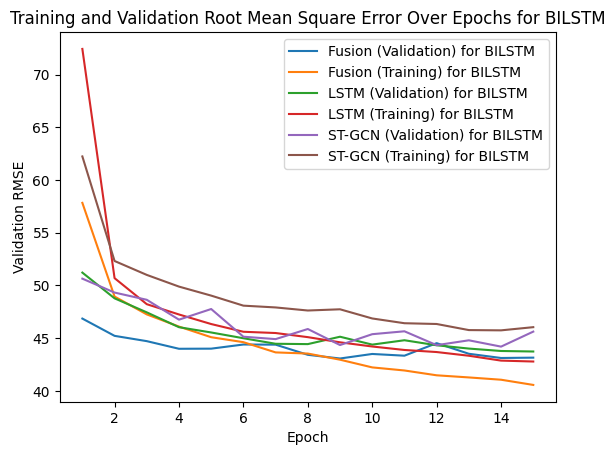

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_bilstm.history['val_rmse'], label='Fusion (Validation) for BILSTM')
plt.plot(epochs_range, history_fusion_bilstm.history['rmse'], label='Fusion (Training) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['val_rmse'], label='LSTM (Validation) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['rmse'], label='LSTM (Training) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['val_rmse'], label='ST-GCN (Validation) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['rmse'], label='ST-GCN (Training) for BILSTM')

plt.title('Training and Validation Root Mean Square Error Over Epochs for BILSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()  # This will use the labels defined above
plt.show()

## Plot - R2 Score (BiLSTM)

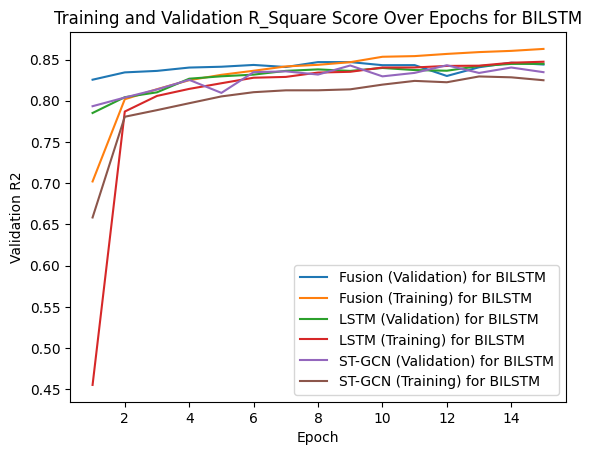

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_bilstm.history['val_r2'], label='Fusion (Validation) for BILSTM')
plt.plot(epochs_range, history_fusion_bilstm.history['r2'], label='Fusion (Training) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['val_r2'], label='LSTM (Validation) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['r2'], label='LSTM (Training) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['val_r2'], label='ST-GCN (Validation) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['r2'], label='ST-GCN (Training) for BILSTM')

plt.title('Training and Validation R_Square Score Over Epochs for BILSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation R2')
plt.legend()  # This will use the labels defined above
plt.show()


## Plot - MAPE (BiLSTM)

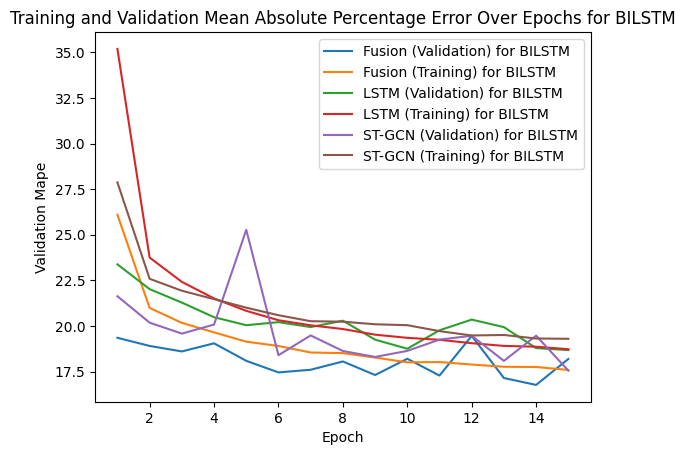

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_bilstm.history['val_mape'], label='Fusion (Validation) for BILSTM')
plt.plot(epochs_range, history_fusion_bilstm.history['mape'], label='Fusion (Training) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['val_mape'], label='LSTM (Validation) for BILSTM')
plt.plot(epochs_range, history_bilstm.history['mape'], label='LSTM (Training) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['val_mape'], label='ST-GCN (Validation) for BILSTM')
plt.plot(epochs_range, history_stgcn2.history['mape'], label='ST-GCN (Training) for BILSTM')

plt.title('Training and Validation Mean Absolute Percentage Error Over Epochs for BILSTM')
plt.xlabel('Epoch')
plt.ylabel('Validation Mape')
plt.legend()  # This will use the labels defined above
plt.show()

## Plot - Loss over Epochs (BiLSTM)

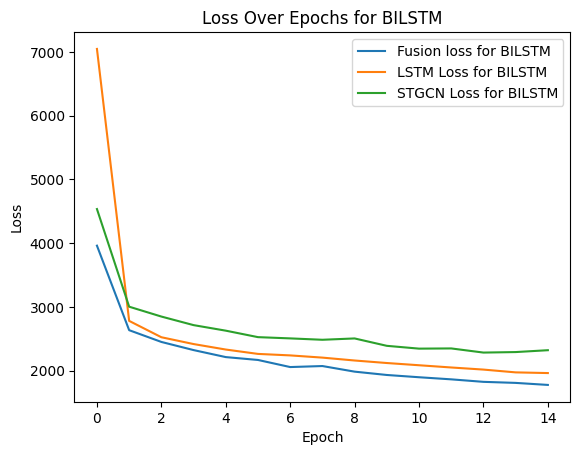

In [ ]:
# Plot validation Loss over Epochs
plt.plot(history_fusion_bilstm.history['loss'], label = 'Fusion loss for BILSTM')
plt.plot(history_bilstm.history['loss'], label = 'LSTM Loss for BILSTM')
plt.plot(history_stgcn2.history['loss'], label = 'STGCN Loss for BILSTM')
plt.title('Loss Over Epochs for BILSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Defintion - STGCN + GRU

In [ ]:
X_shape_stgcn = (5, 11, 1)
X_shape_lstm = (5, 11)

In [ ]:
def create_st_gcn_model3(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer='he_normal')(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = GRU(64, activation='relu', kernel_initializer='he_normal')(x)  # Use Bidirectional LSTM
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model3')
    return model

In [ ]:
def create_gru_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = GRU(32, activation='relu', kernel_initializer=he_normal())(input_layer)  # Replace LSTM with GRU
    model = Model(inputs=input_layer, outputs=x, name='gru_model')  # Update the model name
    return model

In [ ]:
def create_fusion_model(X_shape_stgcn, X_shape_lstm):
    st_gcn_model3 = create_st_gcn_model3(X_shape_stgcn)
    gru_model = create_gru_model(X_shape_lstm)
    combined_input = concatenate([st_gcn_model3.output, gru_model.output])
    fusion_layer3 = Dense(32, activation='relu')(combined_input)
    final_output3 = Dense(1, name='output_layer')(fusion_layer3)
    final_model3 = Model(inputs=[st_gcn_model3.input, gru_model.input], outputs=final_output3)
    return final_model3

In [ ]:
fusion_model_gru = create_fusion_model(X_shape_stgcn, X_shape_lstm)
fusion_model_gru.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

In [ ]:
def st_gcn_model3(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=(1, 3), kernel_initializer=he_normal())(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Flatten())(x)
    x = GRU(64, activation='relu', kernel_initializer=he_normal())(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='st_gcn_model3')
    return model

In [ ]:
stgcn_model3 = st_gcn_model3(X_shape_stgcn)
stgcn_model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape],run_eagerly=True)

In [ ]:
def gru_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = GRU(32, activation='relu', kernel_initializer=he_normal())(input_layer)
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x, name='gru_model')
    return model

In [ ]:
gru_model = gru_model(X_shape_lstm)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                     metrics=['mae', rmse, r2, mape], run_eagerly=True)

### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "model_checkpoint_epoch_{epoch:02d}.h5"  # Include the epoch number in the file name

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=False,  # Save the model at every epoch
    verbose=1
)

# Train the model with the custom callback
history_fusion_gru = fusion_model_gru.fit(
    [X_train_stgcn, X_train_lstm],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = ([X_val_stgcn, X_val_lstm], y_val),
    verbose=1,
    callbacks=[model_checkpoint]
)

Epoch 1/15
1081/1081 [==============================] - ETA: 0s - loss: 4574.0542 - mae: 41.3577 - rmse: 60.6169 - r2: 0.6505 - mape: 27.6619
Epoch 1: saving model to model_checkpoint_epoch_01.h5
1081/1081 [==============================] - 270s 247ms/step - loss: 4574.0542 - mae: 41.3577 - rmse: 60.6169 - r2: 0.6505 - mape: 27.6619 - val_loss: 2536.3789 - val_mae: 32.6841 - val_rmse: 48.7389 - val_r2: 0.8090 - val_mape: 19.9104
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2551.0291 - mae: 30.7157 - rmse: 48.3269 - r2: 0.8101 - mape: 21.1606
Epoch 2: saving model to model_checkpoint_epoch_02.h5
1081/1081 [==============================] - 268s 248ms/step - loss: 2551.0291 - mae: 30.7157 - rmse: 48.3269 - r2: 0.8101 - mape: 21.1606 - val_loss: 2178.5347 - val_mae: 28.7511 - val_rmse: 45.0197 - val_r2: 0.8329 - val_mape: 18.9702
Epoch 3/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2399.9043 - mae: 29.4368 - rmse: 46.8702 - r2: 0.8186 - mape: 20.1725
Epoch 3: saving model to model_checkpoint_epoch_03.h5
1081/1081 [==============================] - 268s 248ms/step - loss: 2399.9043 - mae: 29.4368 - rmse: 46.8702 - r2: 0.8186 - mape: 20.1725 - val_loss: 2099.2368 - val_mae: 27.8294 - val_rmse: 44.2585 - val_r2: 0.8383 - val_mape: 18.2979
Epoch 4/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2273.1863 - mae: 28.5799 - rmse: 45.6670 - r2: 0.8290 - mape: 19.5688
Epoch 4: saving model to model_checkpoint_epoch_04.h5
1081/1081 [==============================] - 277s 256ms/step - loss: 2273.1863 - mae: 28.5799 - rmse: 45.6670 - r2: 0.8290 - mape: 19.5688 - val_loss: 2048.0706 - val_mae: 28.0685 - val_rmse: 43.7578 - val_r2: 0.8443 - val_mape: 19.5103
Epoch 5/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2232.5139 - mae: 28.1887 - rmse: 45.2874 - r2: 0.8308 - mape: 19.2633
Epoch 5: saving model to model_checkpoint_epoch_05.h5
1081/1081 [==============================] - 276s 256ms/step - loss: 2232.5139 - mae: 28.1887 - rmse: 45.2874 - r2: 0.8308 - mape: 19.2633 - val_loss: 2037.0453 - val_mae: 27.5228 - val_rmse: 43.5422 - val_r2: 0.8446 - val_mape: 18.8444
Epoch 6/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2172.6611 - mae: 27.8694 - rmse: 44.7414 - r2: 0.8349 - mape: 19.1023
Epoch 6: saving model to model_checkpoint_epoch_06.h5
1081/1081 [==============================] - 267s 247ms/step - loss: 2172.6611 - mae: 27.8694 - rmse: 44.7414 - r2: 0.8349 - mape: 19.1023 - val_loss: 1972.4916 - val_mae: 27.3509 - val_rmse: 42.9622 - val_r2: 0.8480 - val_mape: 18.2730
Epoch 7/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2159.1062 - mae: 27.5845 - rmse: 44.4631 - r2: 0.8369 - mape: 18.9111
Epoch 7: saving model to model_checkpoint_epoch_07.h5
1081/1081 [==============================] - 274s 254ms/step - loss: 2159.1062 - mae: 27.5845 - rmse: 44.4631 - r2: 0.8369 - mape: 18.9111 - val_loss: 2023.9535 - val_mae: 26.6888 - val_rmse: 43.1633 - val_r2: 0.8502 - val_mape: 18.3484
Epoch 8/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2071.4111 - mae: 27.2015 - rmse: 43.6768 - r2: 0.8433 - mape: 18.6156
Epoch 8: saving model to model_checkpoint_epoch_08.h5
1081/1081 [==============================] - 276s 256ms/step - loss: 2071.4111 - mae: 27.2015 - rmse: 43.6768 - r2: 0.8433 - mape: 18.6156 - val_loss: 1947.7197 - val_mae: 26.6008 - val_rmse: 42.6160 - val_r2: 0.8515 - val_mape: 18.4037
Epoch 9/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2044.2834 - mae: 27.0229 - rmse: 43.2589 - r2: 0.8453 - mape: 18.5344
Epoch 9: saving model to model_checkpoint_epoch_09.h5
1081/1081 [==============================] - 274s 253ms/step - loss: 2044.2834 - mae: 27.0229 - rmse: 43.2589 - r2: 0.8453 - mape: 18.5344 - val_loss: 2037.6875 - val_mae: 26.6265 - val_rmse: 43.3292 - val_r2: 0.8482 - val_mape: 17.1119
Epoch 10/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 2030.5029 - mae: 26.9342 - rmse: 43.2275 - r2: 0.8454 - mape: 18.4476
Epoch 10: saving model to model_checkpoint_epoch_10.h5
1081/1081 [==============================] - 282s 261ms/step - loss: 2030.5029 - mae: 26.9342 - rmse: 43.2275 - r2: 0.8454 - mape: 18.4476 - val_loss: 2047.6794 - val_mae: 26.6974 - val_rmse: 43.1965 - val_r2: 0.8505 - val_mape: 18.1655
Epoch 11/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 1994.6561 - mae: 26.7083 - rmse: 42.9067 - r2: 0.8484 - mape: 18.3316
Epoch 11: saving model to model_checkpoint_epoch_11.h5
1081/1081 [==============================] - 281s 260ms/step - loss: 1994.6561 - mae: 26.7083 - rmse: 42.9067 - r2: 0.8484 - mape: 18.3316 - val_loss: 1974.6204 - val_mae: 26.7220 - val_rmse: 42.6956 - val_r2: 0.8494 - val_mape: 17.6161
Epoch 12/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 1982.5272 - mae: 26.6316 - rmse: 42.7645 - r2: 0.8497 - mape: 18.2412
Epoch 12: saving model to model_checkpoint_epoch_12.h5
1081/1081 [==============================] - 282s 261ms/step - loss: 1982.5272 - mae: 26.6316 - rmse: 42.7645 - r2: 0.8497 - mape: 18.2412 - val_loss: 2011.3113 - val_mae: 26.2108 - val_rmse: 42.9268 - val_r2: 0.8496 - val_mape: 17.3125
Epoch 13/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 1932.9034 - mae: 26.4874 - rmse: 42.3563 - r2: 0.8511 - mape: 18.1511
Epoch 13: saving model to model_checkpoint_epoch_13.h5
1081/1081 [==============================] - 283s 262ms/step - loss: 1932.9034 - mae: 26.4874 - rmse: 42.3563 - r2: 0.8511 - mape: 18.1511 - val_loss: 2026.4424 - val_mae: 26.6102 - val_rmse: 42.9766 - val_r2: 0.8493 - val_mape: 18.2620
Epoch 14/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 1923.2810 - mae: 26.3787 - rmse: 42.1835 - r2: 0.8528 - mape: 18.0563
Epoch 14: saving model to model_checkpoint_epoch_14.h5
1081/1081 [==============================] - 281s 260ms/step - loss: 1923.2810 - mae: 26.3787 - rmse: 42.1835 - r2: 0.8528 - mape: 18.0563 - val_loss: 2003.5795 - val_mae: 26.8722 - val_rmse: 43.1828 - val_r2: 0.8455 - val_mape: 18.3818
Epoch 15/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1081/1081 [==============================] - ETA: 0s - loss: 1886.0861 - mae: 26.3036 - rmse: 41.8719 - r2: 0.8550 - mape: 18.0717
Epoch 15: saving model to model_checkpoint_epoch_15.h5
1081/1081 [==============================] - 281s 260ms/step - loss: 1886.0861 - mae: 26.3036 - rmse: 41.8719 - r2: 0.8550 - mape: 18.0717 - val_loss: 1946.9661 - val_mae: 26.0082 - val_rmse: 42.2465 - val_r2: 0.8534 - val_mape: 17.4017


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Training - GRU Model

In [ ]:
history_gru = gru_model.fit(
    X_train_lstm,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_lstm, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 187s 173ms/step - loss: 9432.8232 - mae: 62.0780 - rmse: 86.7443 - r2: 0.2750 - mape: 41.5736 - val_loss: 4085.9204 - val_mae: 41.3900 - val_rmse: 61.9003 - val_r2: 0.6966 - val_mape: 27.5962
Epoch 2/15
1081/1081 [==============================] - 175s 161ms/step - loss: 3799.3770 - mae: 39.1284 - rmse: 59.3106 - r2: 0.7183 - mape: 28.2400 - val_loss: 3400.8369 - val_mae: 40.3041 - val_rmse: 56.8919 - val_r2: 0.7341 - val_mape: 30.1693
Epoch 3/15
1081/1081 [==============================] - 170s 157ms/step - loss: 3179.4861 - mae: 35.3725 - rmse: 54.1384 - r2: 0.7654 - mape: 25.2973 - val_loss: 2761.8098 - val_mae: 33.4139 - val_rmse: 50.8609 - val_r2: 0.7924 - val_mape: 22.4240
Epoch 4/15
1081/1081 [==============================] - 181s 168ms/step - loss: 2930.5928 - mae: 33.7461 - rmse: 51.7833 - r2: 0.7828 - mape: 24.0527 - val_loss: 2663.2578 - val_mae: 32.5315 - val_rmse: 49.7479 - val_r2: 0.8022 - val_mape: 22.3270
Epoch 5/

### Training - STGCN Model

In [ ]:
history_stgcn3 = stgcn_model3.fit(
    X_train_stgcn,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val_stgcn, y_val),
    verbose=1
)

Epoch 1/15
1081/1081 [==============================] - 228s 211ms/step - loss: 5449.7437 - mae: 45.5806 - rmse: 66.0097 - r2: 0.5957 - mape: 30.0726 - val_loss: 2760.0684 - val_mae: 32.5324 - val_rmse: 50.3090 - val_r2: 0.8008 - val_mape: 21.2354
Epoch 2/15
1081/1081 [==============================] - 223s 207ms/step - loss: 2891.6311 - mae: 33.1614 - rmse: 51.5450 - r2: 0.7851 - mape: 22.4613 - val_loss: 2563.0996 - val_mae: 33.1857 - val_rmse: 49.1028 - val_r2: 0.8057 - val_mape: 20.6520
Epoch 3/15
1081/1081 [==============================] - 234s 217ms/step - loss: 2710.5466 - mae: 31.8975 - rmse: 49.8860 - r2: 0.7956 - mape: 21.5487 - val_loss: 2287.1294 - val_mae: 29.3688 - val_rmse: 46.0725 - val_r2: 0.8299 - val_mape: 20.5349
Epoch 4/15
1081/1081 [==============================] - 233s 215ms/step - loss: 2546.4319 - mae: 30.7605 - rmse: 48.3955 - r2: 0.8066 - mape: 20.9476 - val_loss: 2262.0222 - val_mae: 29.5946 - val_rmse: 45.8049 - val_r2: 0.8321 - val_mape: 19.3773
Epoch 5/

### Plots - MAE (GRU)



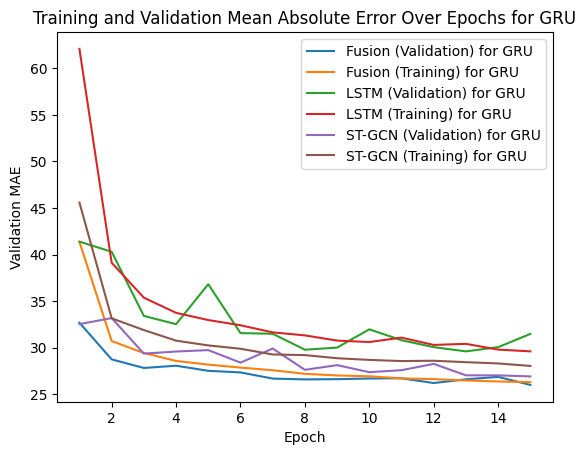

In [ ]:
# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_gru.history['val_mae'], label='Fusion (Validation) for GRU')
plt.plot(epochs_range, history_fusion_gru.history['mae'], label='Fusion (Training) for GRU')
plt.plot(epochs_range, history_gru.history['val_mae'], label='LSTM (Validation) for GRU')
plt.plot(epochs_range, history_gru.history['mae'], label='LSTM (Training) for GRU')
plt.plot(epochs_range, history_stgcn3.history['val_mae'], label='ST-GCN (Validation) for GRU')
plt.plot(epochs_range, history_stgcn3.history['mae'], label='ST-GCN (Training) for GRU')

plt.title('Training and Validation Mean Absolute Error Over Epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - RMSE (GRU)

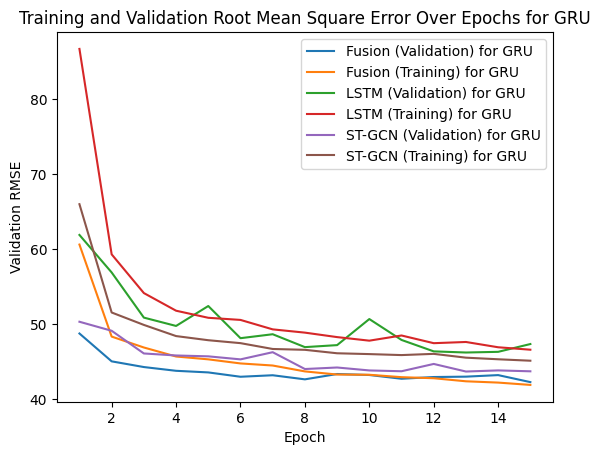

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_gru.history['val_rmse'], label='Fusion (Validation) for GRU')
plt.plot(epochs_range, history_fusion_gru.history['rmse'], label='Fusion (Training) for GRU')
plt.plot(epochs_range, history_gru.history['val_rmse'], label='LSTM (Validation) for GRU')
plt.plot(epochs_range, history_gru.history['rmse'], label='LSTM (Training) for GRU')
plt.plot(epochs_range, history_stgcn3.history['val_rmse'], label='ST-GCN (Validation) for GRU')
plt.plot(epochs_range, history_stgcn3.history['rmse'], label='ST-GCN (Training) for GRU')

plt.title('Training and Validation Root Mean Square Error Over Epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Validation RMSE')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - R2 Score (GRU)

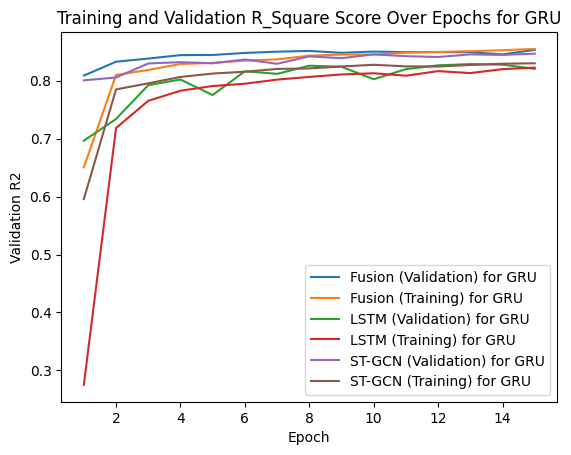

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_gru.history['val_r2'], label='Fusion (Validation) for GRU')
plt.plot(epochs_range, history_fusion_gru.history['r2'], label='Fusion (Training) for GRU')
plt.plot(epochs_range, history_gru.history['val_r2'], label='LSTM (Validation) for GRU')
plt.plot(epochs_range, history_gru.history['r2'], label='LSTM (Training) for GRU')
plt.plot(epochs_range, history_stgcn3.history['val_r2'], label='ST-GCN (Validation) for GRU')
plt.plot(epochs_range, history_stgcn3.history['r2'], label='ST-GCN (Training) for GRU')

plt.title('Training and Validation R_Square Score Over Epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Validation R2')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - MAPE (GRU)

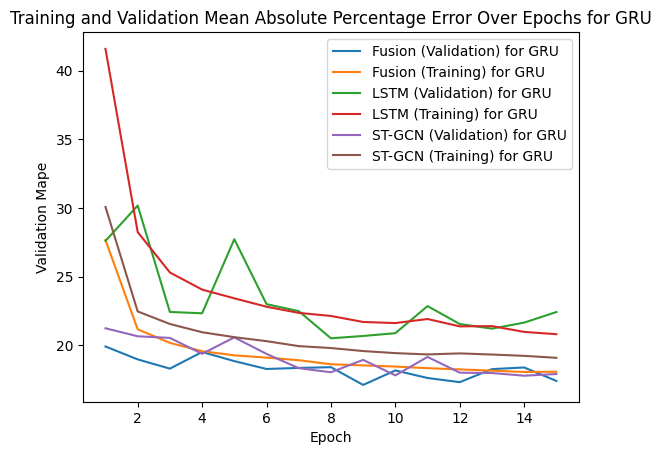

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics
epochs_range = range(1, epochs + 1)

# Plot validation mean absolute error
plt.plot(epochs_range, history_fusion_gru.history['val_mape'], label='Fusion (Validation) for GRU')
plt.plot(epochs_range, history_fusion_gru.history['mape'], label='Fusion (Training) for GRU')
plt.plot(epochs_range, history_gru.history['val_mape'], label='LSTM (Validation) for GRU')
plt.plot(epochs_range, history_gru.history['mape'], label='LSTM (Training) for GRU')
plt.plot(epochs_range, history_stgcn3.history['val_mape'], label='ST-GCN (Validation) for GRU')
plt.plot(epochs_range, history_stgcn3.history['mape'], label='ST-GCN (Training) for GRU')

plt.title('Training and Validation Mean Absolute Percentage Error Over Epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Validation Mape')
plt.legend()  # This will use the labels defined above
plt.show()

### Plots - Loss over Epochs (GRU)

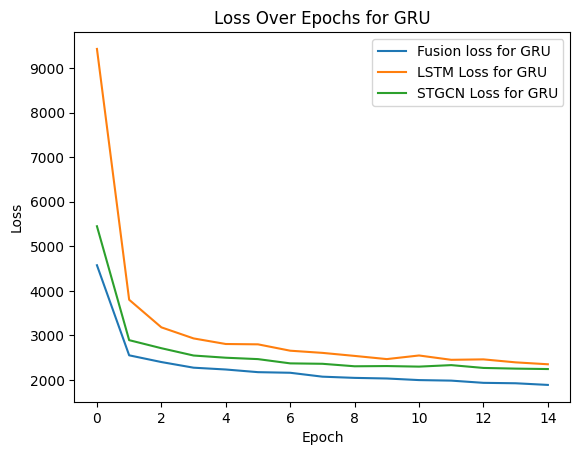

In [ ]:
# Plot validation mean absolute error
plt.plot(history_fusion_gru.history['loss'], label = 'Fusion loss for GRU')
plt.plot(history_gru.history['loss'], label = 'LSTM Loss for GRU')
plt.plot(history_stgcn3.history['loss'], label = 'STGCN Loss for GRU')
plt.title('Loss Over Epochs for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()